# Poisson equation 1D using kernels
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

Consider the following problem on the interval $\Omega = [0,1]$.

> PDE: $-\Delta u(x) = \sin(x)$ for all $x \in \Omega$

> BC's: $u(x)= 0$ for all $x\in \partial \Omega$.

## Libraries

In [1]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
#from parameter_learning import * DONE
#from plotlib import *
#from models import *
#from interpolation import *
#from kernels import * DONE
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jacfwd, vmap, jit
from jax.config import config;
config.update("jax_enable_x64", True)
from sklearn.model_selection import KFold
import scipy.spatial.distance as dist
from functools import partial # for jit to make codes faster

## Utils

### True solution

In [2]:
def u_true(x):
  return -x*jnp.sin(1) + jnp.sin(x)

### Kernels

Kernels to be used:

In [3]:
# Gaussian Kernel
def Gaussian(t,t_,params):
	sigma = params
	r2 = jnp.dot(t-t_,t-t_)
	return jnp.exp(-r2/(2*sigma**2))

 # My Kernel


`vmap` from `JAX` to create Gram matrices and their gradients

In [4]:
def K(kernel, T, T_, params):
	return vmap(lambda t: vmap(lambda t_: kernel(t,t_, params))(T_))(T)

def K_dot(kernel, T ,T_, params, arg):
	K_Dot = jit(grad(kernel,arg))
	return vmap(lambda t: vmap(lambda t_: K_Dot(t, t_, params))(T_))(T)

def K_ddot(kernel, T ,T_, params, arg1, arg2):
	K_2Dot = jit(grad(grad(kernel,arg1),arg2))
	return vmap(lambda t: vmap(lambda t_: K_2Dot(t ,t_, params))(T_))(T)

def K_dddot(kernel, T ,T_, params, arg1, arg2, arg3):
	K_3Dot = jit(grad(grad(grad(kernel,arg1),arg2),arg3))
	return vmap(lambda t: vmap(lambda t_: K_3Dot(t ,t_, params))(T_))(T)

def K_ddddot(kernel, T ,T_, params, arg1, arg2, arg3, arg4):
	K_4Dot = jit(grad(grad(grad(grad(kernel,arg1),arg2),arg3),arg4))
	return vmap(lambda t: vmap(lambda t_: K_4Dot(t ,t_, params))(T_))(T)

### Hyper-parameter learning

In [5]:
def grid_search_RBF(x_train,u_train, grid = False):
  '''
    x_train: N x d array with collocation points.
    u_train: N x 1 values of u at x_train.
    kernel: Kernel to learn its parameters.
    grid: Bool. Output the value of the loss.
  '''

  k1 = 10 # size of grid for sigma
  k2 = 20 # size of grid for regularization
  n_splits = 5


  k = np.linspace(10**-3, 2 , num=k1)
  distances = dist.pdist(x_train) # pairwise distances
  beta = np.median(distances) # median of the pairwise distances
  # Search space for sigma
  sgm = beta*k

  # Search space for lambda
  lmbd = 10**np.linspace(-12, 0, k2)

  scores_rbf = np.zeros((k1, k2))
  scores_std_rbf = np.zeros((k1, k2))

  mses = []

  for i in range(k1):
    sigma = sgm[i]

    for j in range(k2):
      alpha = lmbd[j]

      kf = KFold(n_splits = n_splits)
      mse = 0.

      for l, (train_index, test_index) in enumerate(kf.split(x_train)):
        #print(f"Fold {l}:")
        #print(f"  Train: index={train_index}")
        xtrain, ytrain = x_train[train_index,:], u_train[train_index]
        #print(f"  Test:  index={test_index}")
        xtest, ytest = x_train[test_index,:], u_train[test_index]
        # Train here
        G = K(Gaussian,xtrain,xtrain,sigma)
        M = (G + alpha*jnp.eye(xtrain.shape[0]))
        alphas_lu = jnp.linalg.solve(M,ytrain)

        # Predict on test data
        k_test_train = K(Gaussian,xtest,xtrain,sigma)
        y_pred = np.dot(k_test_train, alphas_lu)

        mse += jnp.mean((y_pred - ytest)**2)

      scores_rbf[i,j] = mse/n_splits

  if grid:
    print('The grid with the loss values is:')
    print('NegMSEs are for every pair of indices: \n {}'.format(np.round(scores_rbf,1)))


  ij_min_rbf = np.array( np.where( scores_rbf == np.nanmin(scores_rbf) ), dtype=int).flatten()
  optim_sgm = sgm[ij_min_rbf[0]]
  optim_lmbd = lmbd[ij_min_rbf[1]]

  return optim_sgm, optim_lmbd

### Interpolation

In [6]:
def kernel_parameters(X_train,U_train):
    '''
    X_train: N x d array with collocation points.
    U_train: N x m array with values of u at X_train.
    '''
    m = U_train.shape[1] # Number of functions
    N = len(X_train)
    optim_sgm = np.zeros(m)
    optim_lmbd = np.zeros(m)
    alphas = np.zeros((N,m))
    for i in range(m):
        optim_sgm[i],optim_lmbd[i] = grid_search_RBF(X_train,U_train[:,i].reshape(-1,1))
        G = K(Gaussian,X_train,X_train,optim_sgm[i])
        M = (G + optim_lmbd[i]*jnp.eye(N))
        alphas[:,i] = jnp.linalg.solve(M,U_train[:,i])
    return optim_sgm, alphas, optim_lmbd

In [7]:
def predictions(X, X_train, kernel, optim_sgm, alphas):
    m = len(optim_sgm)
    N = len(X)
    u_pred      = np.zeros((N,m))
    u_dot_pred  = np.zeros((N,m))
    u_ddot_pred = np.zeros((N,m))
    for i in range(m):
        u_pred[:,i]      = np.dot(K(kernel, X, X_train, optim_sgm[i]), alphas[:,i])
        u_dot_pred[:,i]  = np.dot(K_dot(kernel, X, X_train, optim_sgm[i], 0), alphas[:,i])
        u_ddot_pred[:,i] = np.dot(K_ddot(kernel, X, X_train, optim_sgm[i], 0, 0), alphas[:,i])

### $K(\phi,\phi)$

In [8]:
def Kphiphi_assembly(Xomega, Xboundary, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1
  val = K_ddddot(kernel, Xomega, Xomega, k_param, 0, 0, 1, 1)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val = -K_ddot(kernel, Xomega, Xboundary, k_param, 0, 0)
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [9]:
def Kphi_assembly(Xtest, Xomega, Xboundary, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val = -K_ddot(kernel, Xomega, Xtest, k_param, 0, 0)
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

### Sources

In [10]:
def f(x):
  return jnp.sin(x)

In [11]:
def g(x):
  return jnp.zeros(jnp.size(x))

## Method

### Sample collocation points in $\Omega$

In [12]:
# X_full
Xfull = np.linspace(0,1,52)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
f_omega = f(Xomega)

<ipython-input-10-238a74aab5e3>:2: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  return jnp.sin(x)


### Choose kernel and hyper-parameters

In [13]:
lscale, reg = grid_search_RBF(Xomega.reshape(-1,1),f_omega)

### Build $K(\varphi,\varphi)$

In [14]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, k = 'Gaussian', k_param = lscale)

### Build $y$

In [15]:
y = jnp.concatenate((f_omega,np.zeros((len(Xboundary)),)))

### Compute $K(\varphi,\varphi)^{-1}y$

In [16]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y)

### Compute $K(X_{\text{test}},\varphi)$

In [17]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, k = 'Gaussian', k_param = lscale)

### Compute solution

In [18]:
u_pred = np.dot(Kphi.T,sol)

Plot results

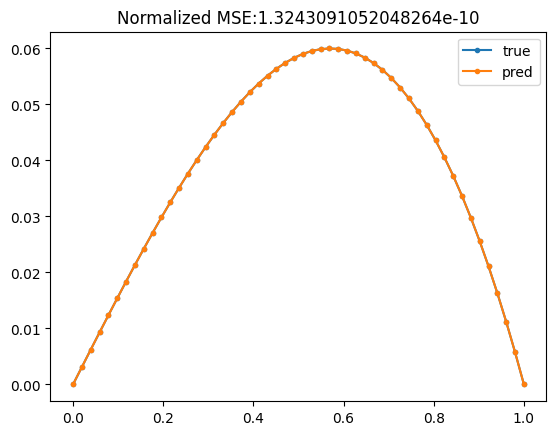

In [19]:
# True solution
plt.plot(Xfull, u_true(Xfull),'.-',label='true')
# Predicted solution
plt.plot(Xfull,u_pred,'.-',label='pred')
# Plot settings
nmse = mean_squared_error(u_pred,u_true(Xfull))/mean_squared_error(0*u_true(Xfull),u_true(Xfull))
plt.title('Normalized MSE:{}'.format(nmse))
plt.legend()
plt.show()

## Problems

1. Reproduce the above problem using the Matérn kernel (define it and also build a function to tune its hyperparameters) for a special case of the Matérn kernel ,e.g., $\nu=1/2$ and comment on the conditioning of the $K(\varphi,\varphi)$ matrix.

2. Generalize the above functions in `JAX` to solve the following Laplace type problem in the unit disk $\Omega$ in the plane:

> PDE: $\Delta u(x,y) = 0$ for all $x \in \Omega$

> BC's: $u(x,y)= \sin(xy)$ for all $x\in \partial \Omega$.
